In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

2025-02-23 00:52:17.797726: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-23 00:52:17.809851: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-23 00:52:17.824679: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-23 00:52:17.828735: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-23 00:52:17.839354: I tensorflow/core/platform/cpu_feature_guar

In [2]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

I0000 00:00:1740264741.672918  144761 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740264741.703238  144761 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740264741.704422  144761 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740264741.706397  144761 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [3]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='/home/ghaidaa/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,

In [4]:
def preprocess(data, augment=False):
    image = tf.image.resize(data['image'], (128, 128))
    mask = tf.image.resize(data['segmentation_mask'], (128, 128))
    
    # Normalize
    image = tf.cast(image, tf.float32) / 255.0
    mask = tf.cast(mask, tf.int32) - 1  # Convert labels 1-3 to 0-2
    
    if augment:
        if tf.random.uniform(()) > 0.5:
            image = tf.image.flip_left_right(image)
            mask = tf.image.flip_left_right(mask)
    
    return image, mask

In [5]:
BATCH_SIZE = 32
train = dataset['train'].map(lambda x: preprocess(x, augment=True))
test = dataset['test'].map(preprocess)

train_dataset = train.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [6]:
def display_predictions(model, dataset=None, num=1):
    if dataset is None:
        sample = next(iter(test_dataset.take(1)))
        images, masks = sample
    else:
        images, masks = next(iter(dataset.take(num)))
    
    pred_masks = model.predict(images)
    pred_masks = tf.argmax(pred_masks, axis=-1)
    
    plt.figure(figsize=(15, 5))
    for i in range(len(images)):
        plt.subplot(1, 3, 1)
        plt.imshow(images[i])
        plt.title('Input Image')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(masks[i])
        plt.title('True Mask')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(pred_masks[i])
        plt.title('Predicted Mask')
        plt.axis('off')
        
        plt.show()

In [7]:
def build_resnet_unet(input_shape=(128, 128, 3), num_classes=3):
    base_model = tf.keras.applications.ResNet50(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    
    layer_names = [
        'conv2_block3_out',
        'conv3_block4_out',
        'conv4_block6_out', 
        'conv5_block3_out',  
    ]
    base_outputs = [base_model.get_layer(name).output for name in layer_names]
    
    encoder = tf.keras.Model(inputs=base_model.input, outputs=base_outputs)
    encoder.trainable = False

    inputs = tf.keras.layers.Input(shape=input_shape)
    skips = encoder(inputs)
    x = skips[-1]
    
    skip_connections = reversed(skips[:-1])
    
    for skip, _ in zip(skip_connections, [256, 256, 256, 256]):
        x = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=2, padding='same')(x)
        x = tf.keras.layers.Concatenate()([x, skip])
        x = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same')(x)
    x = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same')(x)
    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='softmax')(x)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [8]:
model = build_resnet_unet()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=15
)

Epoch 1/15


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
I0000 00:00:1740264760.680818  144858 service.cc:146] XLA service 0x7fde50003390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740264760.680887  144858 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-02-23 00:52:40.939400: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1740264761.469995  144858 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-02-23 00:52:42.085369: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2025-02-23 00:52:44.738013: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allo

  1/115 ━━━━━━━━━━━━━━━━━━━━ 45:34 24s/step - accuracy: 0.3310 - loss: 1.1508

I0000 00:00:1740264778.761810  144858 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.6445 - loss: 0.8429

W0000 00:00:1740264796.263613  144857 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-02-23 00:53:16.698796: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.81GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
W0000 00:00:1740264806.018778  144850 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-02-23 00:53:28.091587: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available

115/115 ━━━━━━━━━━━━━━━━━━━━ 57s 286ms/step - accuracy: 0.6450 - loss: 0.8421 - val_accuracy: 0.5855 - val_loss: 2.3268
Epoch 2/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 23s 202ms/step - accuracy: 0.7486 - loss: 0.6361 - val_accuracy: 0.6295 - val_loss: 0.9070
Epoch 3/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 24s 205ms/step - accuracy: 0.7647 - loss: 0.5968 - val_accuracy: 0.7538 - val_loss: 0.6259
Epoch 4/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 24s 210ms/step - accuracy: 0.7696 - loss: 0.5834 - val_accuracy: 0.7376 - val_loss: 0.6709
Epoch 5/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 25s 215ms/step - accuracy: 0.7755 - loss: 0.5686 - val_accuracy: 0.7452 - val_loss: 0.6330
Epoch 6/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 25s 219ms/step - accuracy: 0.7788 - loss: 0.5596 - val_accuracy: 0.7424 - val_loss: 0.6525
Epoch 7/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 25s 216ms/step - accuracy: 0.7824 - loss: 0.5485 - val_accuracy: 0.7529 - val_loss: 0.6304
Epoch 8/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 25s 216ms/step - accuracy: 0.7852 - loss: 0.5451 - val

In [10]:
model.save('resnet_unet_segmentation.keras')

In [11]:
model = tf.keras.models.load_model('resnet_unet_segmentation.keras')

/home/ghaidaa/anaconda3/envs/tf_env_v2/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 26 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


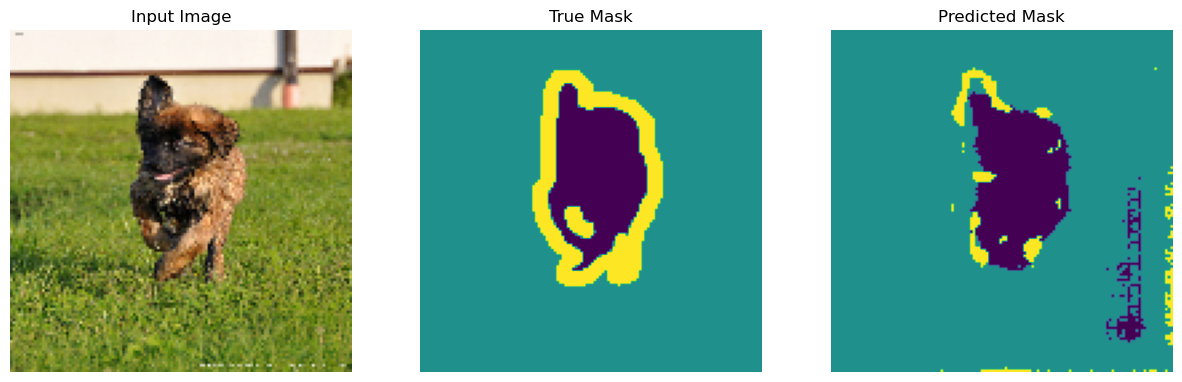

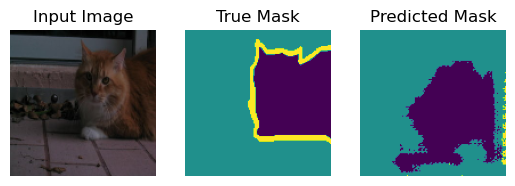

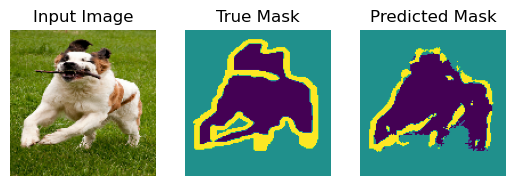

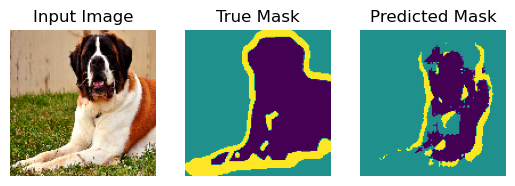

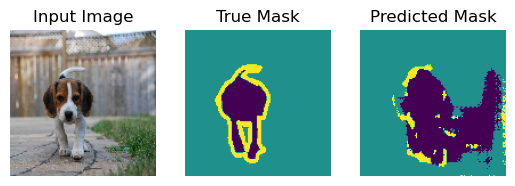

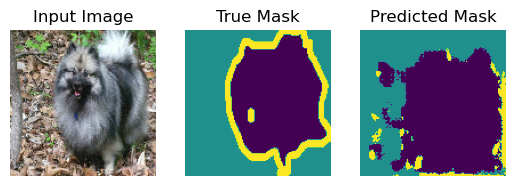

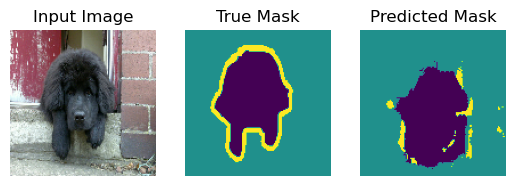

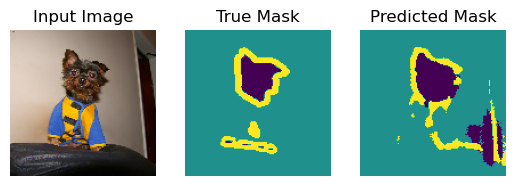

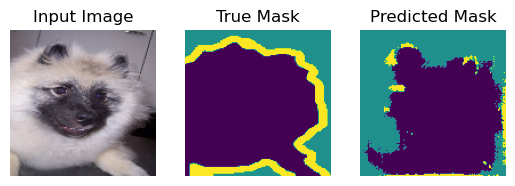

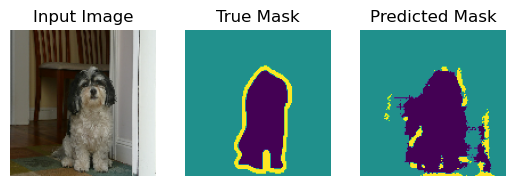

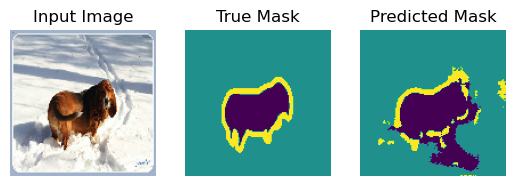

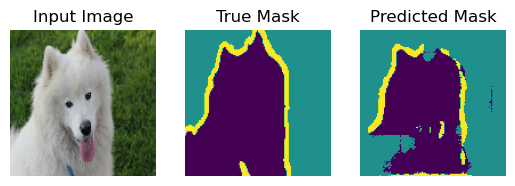

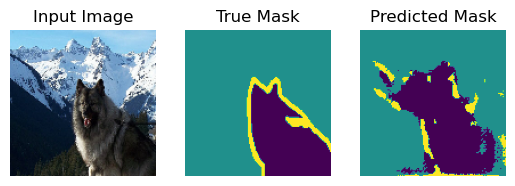

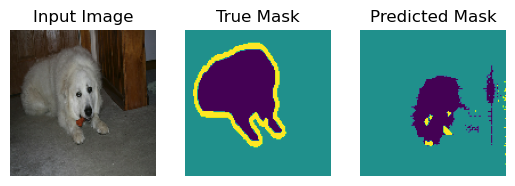

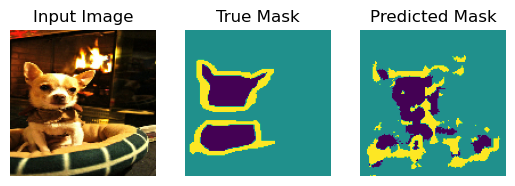

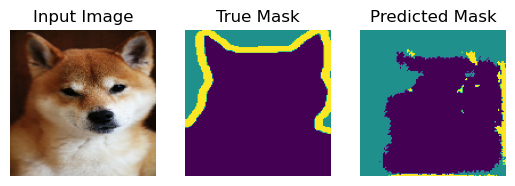

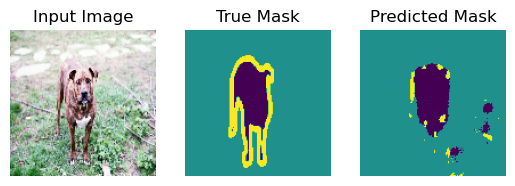

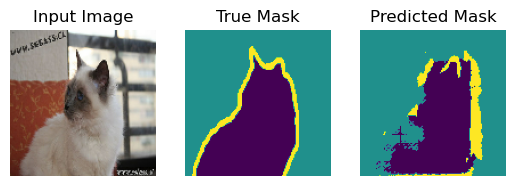

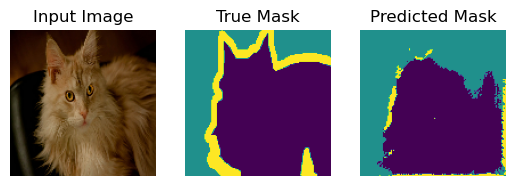

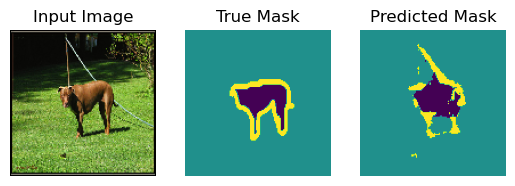

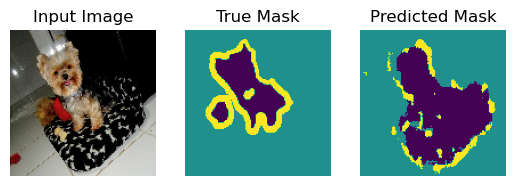

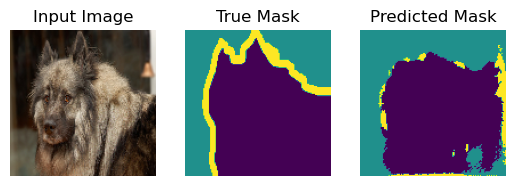

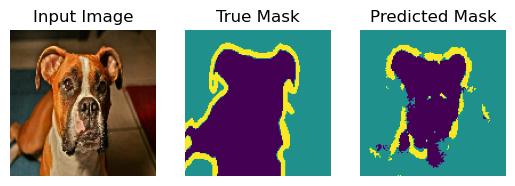

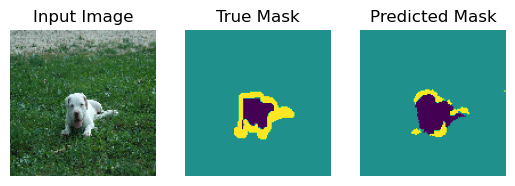

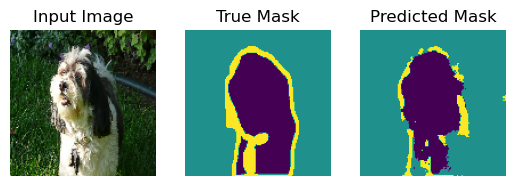

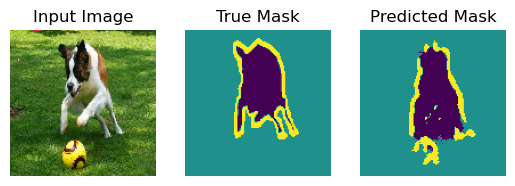

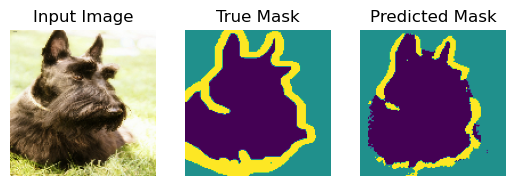

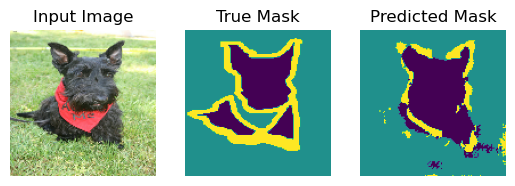

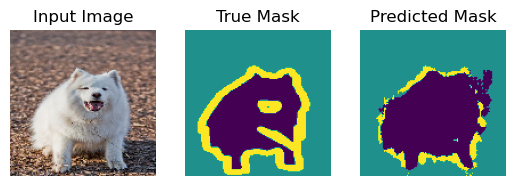

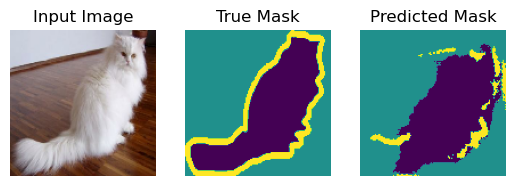

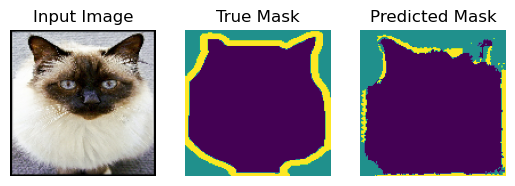

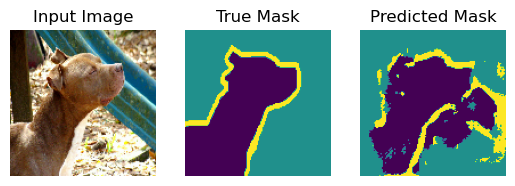

In [12]:
display_predictions(model, test_dataset)